Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

Why Embedding?

Traditional natural language processing systems traditionally treat words as discrete atomic symbols, and therefore 'cat' may be represented as Id537 and 'dog' as Id143. These encodings are arbitrary, and provide no useful information to the system regarding the relationships that may exist between the individual symbols.

Vector space models (VSMs) represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other').

There are two methods for VSM or embedding, count-based methods (e.g. Latent Semantic Analysis), and predictive methods (e.g. neural probabilistic language models).

Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1 and 3.2 in Mikolov et al.). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. 


In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:
words[0]

'anarchism'

In [6]:
words[-1]

'b'

Build the dictionary and replace rare words with UNK token.

In [7]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5236, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [8]:
count

[['UNK', 418391],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 

In [9]:
dictionary

{'smallholders': 42988,
 'gdi': 47894,
 'commemorates': 19087,
 'gets': 3691,
 'poseidon': 13206,
 'notes': 1038,
 'pcr': 24173,
 'existentialism': 12098,
 'repel': 19223,
 'ordered': 1894,
 'ccd': 18036,
 'ethnically': 11367,
 'works': 312,
 'rahul': 42435,
 'scary': 26604,
 'carrel': 18393,
 'folkestone': 44612,
 'vigour': 35232,
 'waikato': 41515,
 'costly': 9552,
 'wooded': 19025,
 'nebraska': 7350,
 'reprogramming': 42433,
 'acceded': 21886,
 'bio': 10844,
 'fit': 2641,
 'denial': 9127,
 'yoda': 39715,
 'thelema': 26328,
 'anhui': 41050,
 'lipoprotein': 37431,
 'diatomaceous': 40562,
 'splitting': 10150,
 'penguins': 16913,
 'represents': 2169,
 'auxiliary': 6566,
 'awacs': 34948,
 'brubaker': 44778,
 'sturluson': 22614,
 'reasoned': 20940,
 'infatuated': 38935,
 'gon': 18790,
 'marsh': 10355,
 'playoff': 6633,
 'dutt': 36684,
 'engineering': 1072,
 'spivak': 44051,
 'bader': 46294,
 'seconded': 40132,
 'lucid': 9633,
 'chattel': 45241,
 'croydon': 12037,
 'cezanne': 42989,
 'drif

In [10]:
reverse_dictionary

{0: 'UNK',
 1: 'the',
 2: 'of',
 3: 'and',
 4: 'one',
 5: 'in',
 6: 'a',
 7: 'to',
 8: 'zero',
 9: 'nine',
 10: 'two',
 11: 'is',
 12: 'as',
 13: 'eight',
 14: 'for',
 15: 's',
 16: 'five',
 17: 'three',
 18: 'was',
 19: 'by',
 20: 'that',
 21: 'four',
 22: 'six',
 23: 'seven',
 24: 'with',
 25: 'on',
 26: 'are',
 27: 'it',
 28: 'from',
 29: 'or',
 30: 'his',
 31: 'an',
 32: 'be',
 33: 'this',
 34: 'which',
 35: 'at',
 36: 'he',
 37: 'also',
 38: 'not',
 39: 'have',
 40: 'were',
 41: 'has',
 42: 'but',
 43: 'other',
 44: 'their',
 45: 'its',
 46: 'first',
 47: 'they',
 48: 'some',
 49: 'had',
 50: 'all',
 51: 'more',
 52: 'most',
 53: 'can',
 54: 'been',
 55: 'such',
 56: 'many',
 57: 'who',
 58: 'new',
 59: 'used',
 60: 'there',
 61: 'after',
 62: 'when',
 63: 'into',
 64: 'american',
 65: 'time',
 66: 'these',
 67: 'only',
 68: 'see',
 69: 'may',
 70: 'than',
 71: 'world',
 72: 'i',
 73: 'b',
 74: 'would',
 75: 'd',
 76: 'no',
 77: 'however',
 78: 'between',
 79: 'about',
 80: 'over'

Function to generate a training batch for the skip-gram model.

In [11]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'anarchism', 'term', 'a', 'of', 'as', 'originated', 'term']


Train a skip-gram model.

In [12]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.007641
Nearest to some: hull, regrets, pep, shel, tuatha, expedition, hausa, militarily,
Nearest to time: undesired, nw, nc, pair, trax, split, pruitt, exchanger,
Nearest to who: idealism, intercept, sown, nonempty, harriman, snows, tipton, isaacson,
Nearest to to: shipments, oblique, halfdan, nell, electroplating, disillusionment, incompatible, accrington,
Nearest to four: seagull, federline, aclu, encircled, resinous, freeing, notably, affreightment,
Nearest to used: gardnerian, coniferous, tod, bronchitis, fiction, milgrom, congresses, malted,
Nearest to as: presumption, environs, mei, alligator, metabolize, roses, herald, esque,
Nearest to up: preposition, bioinformatics, kary, saturday, cker, mystical, expand, nicomachean,
Nearest to use: them, assemble, sectarianism, medicines, logik, reversed, ipf, benitez,
Nearest to an: indicator, muharram, quote, possessor, neodymium, rth, biopolymers, despised,
Nearest to other: meltwater, wo, credit, ja

In [14]:
num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

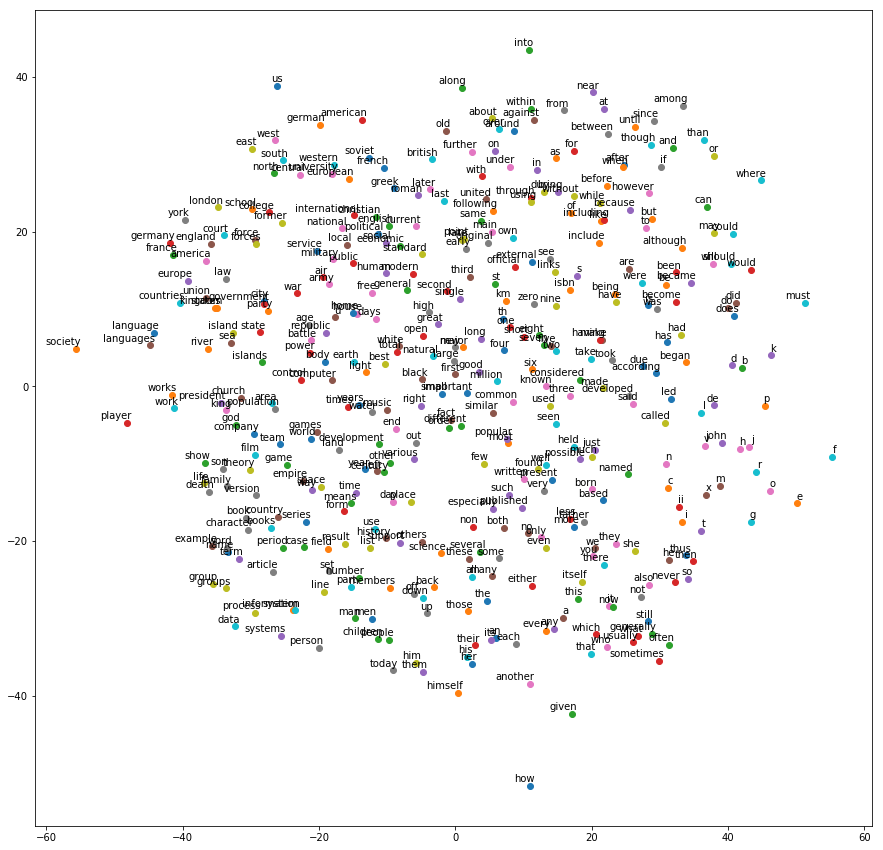

In [15]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

collections: 

High-performance container datatypes

collections.deque:

list-like container with fast appends and pops on either end

#### Build batch generation for cbow

In [39]:
def generate_cbow_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # Here batch should be decided by num_skips * batch_size array
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    # define a temp array to store batch
    batch_temp = np.ndarray(shape=(num_skips), dtype=np.int32)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch_temp[j] = buffer[target]
    # after store the data in temp, then switch to batchs and labels
    batch[i] = batch_temp
    labels[i,0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [41]:
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print(batch)
    print(labels)
    print('    batch:', [[reverse_dictionary[ni] for ni in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
[[5236   12]
 [3081    6]
 [  12  195]
 [   6    2]
 [ 195 3134]
 [   2   46]
 [3134   59]
 [  46  156]]
[[3081]
 [  12]
 [   6]
 [ 195]
 [   2]
 [3134]
 [  46]
 [  59]]
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
[[ 195 5236    6 3081]
 [   2 3081  195   12]
 [  12 3134    2    6]
 [3134   46    6  195]
 [ 195   59    2   46]
 [   2   59 3134  156]
 [ 128   46  156 3134]
 [  59   46  742  128]]
[[  12]
 [   6]
 [ 195]
 [   2]
 [3134]
 [  46]
 [  59]
 [ 156]]
    batch: [['term', 'anarchism', 'a', 'originated'], ['of', 'originated', 'term', 'as'], ['as', 'abuse', 'of', 'a'], ['abuse', 'first', 'a', 'term'], ['term', 'used', 'of', 'first'], ['of', 'used', 'abuse', 'against'], ['early', 'first', 'against', 'abuse'], 

#### Adjust the loss function from softmax (multi-classify) to nce( noise-contrastive estimation)

In [44]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  # change the training dataset format to num_skips*batch_size 2d-array
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  # as mention at https://www.tensorflow.org/tutorials/word2vec#scaling_up_with_noise-contrastive_training
  # for CBOW, won't use softmax, but use noise-contrastive estimation (NCE) loss for CBOW.
  ## softmax_weights = tf.Variable(
  ## tf.truncated_normal([vocabulary_size, embedding_size],
  ##                       stddev=1.0 / math.sqrt(embedding_size)))
  ## softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  
  # since embedding had num_skips context words, we want to reduce from num_skips to 1
  reduced_embed = tf.div(tf.reduce_sum(embed, 1), num_skips)
  
  # Construct the variables for the NCE loss
  nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # Compute the softmax loss, using a sample of the negative labels each time time we evaluate the loss.
    
  loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, inputs=reduced_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [45]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, num_bags, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 282.809296
Nearest to after: fandom, jenkins, gee, assad, colossal, aforementioned, masers, eec,
Nearest to while: vegetative, piedmont, logicians, translate, ashoka, zea, uniqueness, carina,
Nearest to would: microbial, bridles, implantation, assessed, lamborghini, velocities, aldus, stroll,
Nearest to used: frisian, reichsf, mayhew, usps, rgensen, intv, rohmer, umpire,
Nearest to such: widowers, ioan, disgusted, bathe, loa, fitzroy, lovecraft, roleplay,
Nearest to people: directs, macbeth, maneuvers, puerto, chairman, blames, sculptures, academically,
Nearest to that: shootings, nepal, pkn, croesus, customer, borges, indifference, mep,
Nearest to three: leonardo, traversing, tesla, weightings, irwin, senegalese, shank, graphing,
Nearest to not: lemay, arcueil, surface, unverifiable, speer, currying, grandfather, maoism,
Nearest to or: josh, summarizes, randy, galician, apoplexy, ara, shipboard, chores,
Nearest to into: reverses, kangaroo, transform

In [48]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

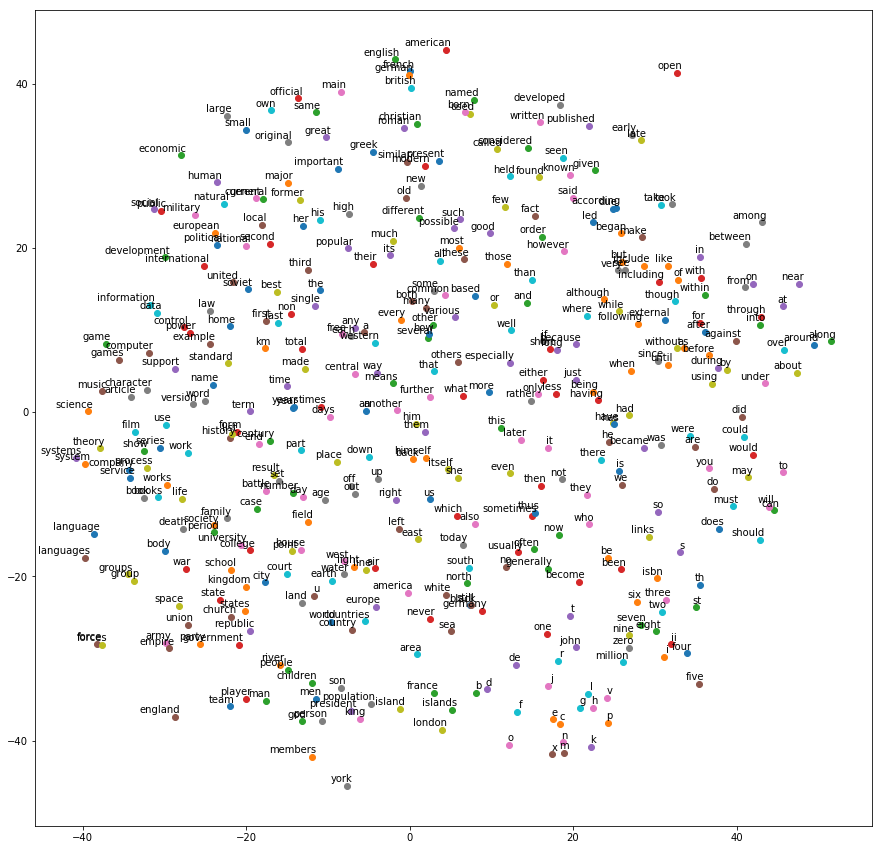

In [49]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)
